# Lecture 7 : Introduction to C Structures

# Part 1 : Working with 2d data in Python

## Let's start by creating a file containing 9 points in 2d.

In [1]:
%%writefile points9.txt
3 4
1 2
-1 5
-2 4
4 3
-3 2
2 5
0 3
5 1

Overwriting points9.txt


## Here is a Python script that will plot a 2d dataset as a .png image.

In [2]:
%%writefile plot2d.py
import sys
import numpy as np
import matplotlib.pyplot as plt

# the name of the output file is a command line argument
if (len(sys.argv) < 2):
    print ("Command Usage : python3",sys.argv[0],"outfile")
    exit(1)
outfile = sys.argv[1]

# read the data file
data = np.loadtxt(sys.stdin)

# plot the data
plt.gca().set_aspect('equal')
plt.scatter(data[:,0],data[:,1],s=20,color='black')

# save the plot as an image
plt.savefig(outfile)

Overwriting plot2d.py


## Let's plot the points as an image.

In [3]:
!cat points9.txt | python3 plot2d.py points9.png

## Display the points9.png image in the Jupyter notebook.

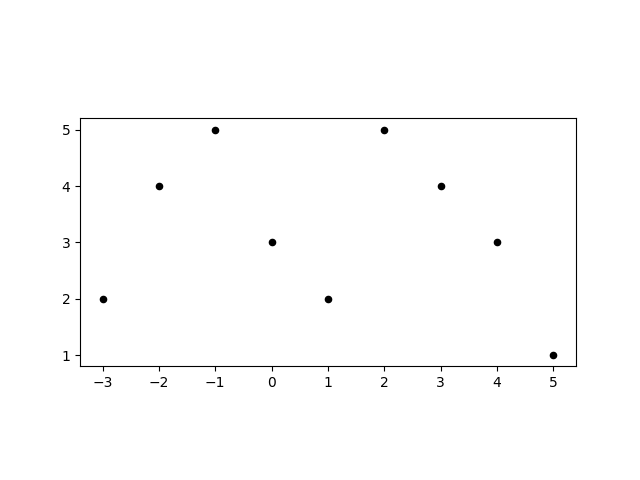

In [4]:
from IPython import display
display.Image("points9.png")

# Part 2 : The Basics of Using C Structures

## We want to write a C program what will find the 2d point that is farthest from the origin.

## It is natural to use a C structure to store a 2d point.

## Let's learn about C structures.

## The following program does not work as expected.  Why not?  

## How can you fix it?

In [5]:
%%writefile add_v1.c
#include <stdio.h>

typedef struct vec2_s {
    double x,y;
} vec2;

void vec2_add (vec2 a, vec2 b, vec2 c) {
    c.x = a.x + b.x;
    c.y = a.y + b.y;
}

int main () {
    vec2 u = { 1.0, 2.0 };
    vec2 v = { 2.0, 3.0 };
    vec2 w = { 0, 0 };
    vec2_add(u,v,w);
    printf ("%.2f %.2f\n",w.x,w.y);
}

Overwriting add_v1.c


In [6]:
!gcc -o add_v1 add_v1.c

In [7]:
!./add_v1

0.00 0.00


## Remember that C passes arguments by value!

## We can fix this code by passing the third argument by pointer.

## Note that c->x is short for (*c).x

In [8]:
%%writefile add_v2.c
#include <stdio.h>

typedef struct vec2_s {
    double x,y;
} vec2;

void vec2_add (vec2 a, vec2 b, vec2* c) {
    c->x = a.x + b.x;
    c->y = a.y + b.y;
}

int main () {
    vec2 u = { 1.0, 2.0 };
    vec2 v = { 2.0, 3.0 };
    vec2 w = { 0, 0 };
    vec2_add(u,v,&w);
    printf ("%.2f %.2f\n",w.x,w.y);
}

Overwriting add_v2.c


In [9]:
!gcc -o add_v2 add_v2.c

In [10]:
!./add_v2

3.00 5.00


## Here is a second way to fix the vector addition without using pointers.

In [11]:
%%writefile add_v3.c
#include <stdio.h>

typedef struct vec2_s {
    double x,y;
} vec2;

vec2 vec2_add (vec2 a, vec2 b) {
    vec2 c = { a.x + b.x, a.y + b.y };
    return c;
}

int main () {
    vec2 u = { 1.0, 2.0 };
    vec2 v = { 2.0, 3.0 };
    vec2 w = vec2_add(u,v);
    printf ("%.2f %.2f\n",w.x,w.y);
}

Overwriting add_v3.c


In [12]:
!gcc -o add_v3 add_v3.c

In [13]:
!./add_v3

3.00 5.00


## The third version seems tempting because pointers are not required.

## However there are some pitfalls to keep in mind when passing C structures by value.  

## Discussion: Why does the following code take so long to run?



In [14]:
%%writefile set_v1.c
#include <stdio.h>

typedef struct vec100k_s {
    double x[100000];
} vec100k;

vec100k vec100k_set (vec100k a, int i, double b) {
    a.x[i] = b;
    return a;
}

int main () {
    vec100k v;
    for (int i=0;i<100000;i++) {
        v = vec100k_set (v,i,i);
    }
    printf ("x[12345] = %.2f",v.x[12345]);
}

Overwriting set_v1.c


In [15]:
!gcc -o set_v1 set_v1.c

In [16]:
!time ./set_v1

x[12345] = 12345.00
real	0m15.424s
user	0m10.811s
sys	0m0.034s


## Passing large C structures by value in C is rarely a good idea.  

## Instead we should always pass large C structures by pointer for efficiency.  

## In fact, if we pass the large C structure by pointer for efficiency, we do not need the return value!

In [17]:
%%writefile set_v2.c
#include <stdio.h>

typedef struct vec100k_s {
    double x[100000];
} vec100k;

void vec100k_set (vec100k* a, int i, double b) {
    a->x[i] = b;
}

int main () {
    vec100k v;
    for (int i=0;i<100000;i++) {
        vec100k_set (&v,i,i);
    }
    printf ("x[12345] = %.2f",v.x[12345]);
}

Overwriting set_v2.c


In [18]:
!gcc -o set_v2 set_v2.c

In [19]:
!time ./set_v2

x[12345] = 12345.00
real	0m0.004s
user	0m0.001s
sys	0m0.002s


# Part 3 : Finding the 2d Point Farthest from the Origin

## Let's proceed to write a C program that finds the 2d point farthest from the origin.

## Note that this problem is equivalent to maximizing the norm (or length) of the input vectors.  

## Recall that the norm (or length) of a vector in $\mathbb{R}^2$ is given by
$$\Large{\| x \| = \sqrt{ x_1^2 + x_2^2}}$$

## Since for positive numbers $x$, $y$ we have that $x^2 > y^2$ if and only if $x > y$, maximizing $\| x \|$ is equivalent to maximizing the norm squared:
$$\Large{\| x \|^2 = x_1^2 + x_2^2}$$

## This trick allows us to avoid the use of the *sqrt* function which is expensive to compute.

## Here is a short *proof* of the key result:  Suppose $x > 0$ and $y > 0$.  Then
$$x^2 > y^2 \Leftrightarrow x^2 - y^2 > 0 \Leftrightarrow (x-y)(x+y) > 0 \Leftrightarrow x-y > 0 \Leftrightarrow x > y$$



In [20]:
%%writefile farthest.c
#include <stdio.h>

typedef struct vec2_s {
    double x,y;
} vec2;

double vec2_norm_sq (vec2 v) {
    return v.x*v.x + v.y*v.y;
}

int main () {
    vec2 farthest;
    vec2 next;
    double max_norm_sq = 0;
    while (scanf("%lf %lf",&(next.x),&(next.y)) == 2) {
        double norm_sq = vec2_norm_sq(next);
        if (norm_sq > max_norm_sq) {
            max_norm_sq = norm_sq;
            farthest = next;
        }
    }
    printf ("The point farthest from the origin is (%.4f,%.4f)\n",
            farthest.x,farthest.y);
}

Overwriting farthest.c


In [21]:
!gcc -o farthest farthest.c

In [22]:
cat points9.txt | ./farthest

The point farthest from the origin is (2.0000,5.0000)


# Part 4 : Finding the Extreme Pair of Points

## In the next example we wish to find the pair of points that are farthest apart.  

## We will call this pair the **extreme pair**.  

## We will use a brute force approach that checks all possible pairs of points.

## Given $n$ points, there are $\binom{n}{2} = \frac{n(n-1)}{2}$ possible pairs of points.  

## A proof of this fact is that you first pick a point (n choices) and then a second point (n-1 choices) but then you have counted each pair twice since (x,y) and (y,x) are the same pair!

## When enumerating all pairs of points we will use the indices $0, 1, 2, ..., n-1$ of the points.  

## Let's first write a C program to count the number of pairs of indices $0, 1, 2, ..., n-1$.  

## We can avoid repeating the pairs by only counting pairs $(i,j)$ such that $i < j$.  

## Note that this approach also avoids counting $(i,i)$ as a pair.

## Here is our first attempt.  

In [23]:
%%writefile count_v1.c
#include <stdio.h>
#include <stdlib.h>

int main (int argc, char* argv[]) {
    if (argc < 2) {
        printf ("command usage: %s %s\n",argv[0],"n");
        return 1;
    }
    int n = atoi(argv[1]);
    int num_pairs = 0;
    for (int i=0;i<n;i++) {
        for (int j=0;j<n;j++) {
            if (i<j) {
                num_pairs += 1;
            }
        }
    }
    printf ("There are %d possible pairs of %d points.\n",num_pairs,n);
}


Overwriting count_v1.c


In [24]:
!gcc -o count_v1 count_v1.c

In [25]:
!./count_v1 10

There are 45 possible pairs of 10 points.


In [26]:
!time ./count_v1 50000

There are 1249975000 possible pairs of 50000 points.

real	0m7.851s
user	0m7.705s
sys	0m0.013s


## We can enumerate the pairs more efficiently by starting the second loop at $i+1$ instead of $0$!

## This change also eliminates the need for the *if* statement.

## Another slight improvement would be to end the first loop when i is n-1 instead of when i is n.  

## Why can we do this?

In [27]:
%%writefile count_v2.c
#include <stdio.h>
#include <stdlib.h>

int main (int argc, char* argv[]) {
    if (argc < 2) {
        printf ("command usage: %s %s\n",argv[0],"n");
        return 1;
    }
    int n = atoi(argv[1]);
    int num_pairs = 0;
    for (int i=0;i<n-1;i++) {
        for (int j=i+1;j<n;j++) {
            num_pairs += 1;
        }
    }
    printf ("There are %d possible pairs of %d points.\n",num_pairs,n);
}

Overwriting count_v2.c


In [28]:
!gcc -o count_v2 count_v2.c

In [29]:
!time ./count_v2 50000

There are 1249975000 possible pairs of 50000 points.

real	0m2.461s
user	0m2.431s
sys	0m0.005s


## Let's modify the counting program to enumerate the pairs.

In [30]:
%%writefile pairs.c
#include <stdio.h>
#include <stdlib.h>

int main (int argc, char* argv[]) {
    if (argc < 2) {
        printf ("command usage: %s %s\n",argv[0],"n");
        return 1;
    }
    int n = atoi(argv[1]);
    for (int i=0;i<n-1;i++) {
        for (int j=i+1;j<n;j++) {
            printf ("%d %d\n",i,j);
        }
    }
}

Overwriting pairs.c


In [31]:
!gcc -o pairs pairs.c

In [32]:
!./pairs 5

0 1
0 2
0 3
0 4
1 2
1 3
1 4
2 3
2 4
3 4


## Exercise : Given $n$ points there are $\binom{n}{3}$ possible triples of the points.  

## Write an efficient C program to compute all triples of the indices $0, 1, 2, ..., n-1$.  

## Try your program with $n=5$.  It should output $\binom{5}{3} = 10$ distinct triples of the indices $0, 1, 2, 3, 4$.  

## We are know ready to write the program to find the **extreme pair**.  

## We will have store the 2d points in an array.

## We will assume that the input file contains at most $1000$ points.

## To find the pair with the maximum distance we will need to maximize
$$\Large{\| u - v \|}$$
## over all possible pairs of points which is equivalent to maximizing
$$\Large{\| u - v \|^2}$$

In [33]:
%%writefile extreme.c
#include <stdio.h>

#define MAX_POINTS 1000

typedef struct vec2_s {
    double x,y;
} vec2;

double vec2_dist_sq (vec2 u, vec2 v) {
    return (u.x-v.x)*(u.x-v.x)+(u.y-v.y)*(u.y-v.y);
}

int main () {

    // read the points from stdin
    int num_points = 0;
    vec2 next;
    vec2 data[MAX_POINTS];
    while (scanf("%lf %lf",&(next.x),&(next.y)) == 2) {
        if (num_points < MAX_POINTS) {
            data[num_points] = next;
            num_points += 1;
        } else {
            printf ("too many points!\n");
            return 1;
        }
    }

    // find the extreme pair
    double max_dist_sq = 0;
    int extreme_i, extreme_j;
    for (int i=0;i<num_points-1;i++) {
        for (int j=i+1;j<num_points;j++) {
            double dist_sq = vec2_dist_sq(data[i],data[j]);
            if (dist_sq > max_dist_sq) {
                max_dist_sq = dist_sq;
                extreme_i = i;
                extreme_j = j;
            }
        }
    }

    // print the results
    printf ("The extreme pair has indices (%d,%d)\n",extreme_i,extreme_j);
}

Overwriting extreme.c


In [34]:
!gcc -o extreme extreme.c

In [35]:
!cat points9.txt | ./extreme

The extreme pair has indices (5,8)


## Here is a Python script for visualizing the extreme pair.

In [36]:
%%writefile extreme.py
import sys
import numpy as np
import matplotlib.pyplot as plt

# the name of the output file is a command line argument
if (len(sys.argv) < 2):
    print ("Command Usage : python3",sys.argv[0],"outfile")
    exit(1)
outfile = sys.argv[1]

# read the data file
data = np.loadtxt(sys.stdin)

# plot the data
plt.gca().set_aspect('equal')
plt.scatter(data[:,0],data[:,1],s=20,color='black')

# plot the special points (if additional command line argments present)
for k in range(2,len(sys.argv)):
    i = int(sys.argv[k])
    plt.scatter (data[i,0],data[i,1],s=100,color='orange')

# save the plot as an image
plt.savefig(outfile)

Overwriting extreme.py


In [37]:
!cat points9.txt | python3 extreme.py points9.png 5 8

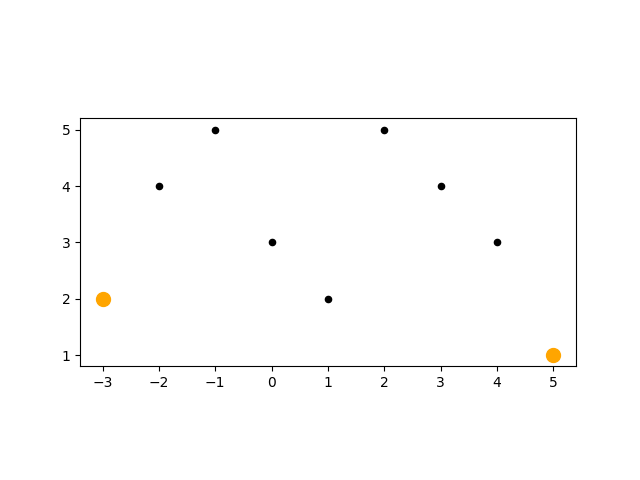

In [38]:
from IPython import display
display.Image("points9.png")

## We close with a version of extreme that uses a function to enhance readability of the code.

In [39]:
%%writefile extreme_fun.c
#include <stdio.h>

#define MAX_POINTS 1000

typedef struct vec2_s {
    double x,y;
} vec2;

double vec2_dist_sq (vec2 u, vec2 v) {
    return (u.x-v.x)*(u.x-v.x)+(u.y-v.y)*(u.y-v.y);
}

void extreme_pair (vec2 data[], int num_points, int* extreme_i, int* extreme_j) {
    double max_dist_sq = 0;
    for (int i=0;i<num_points-1;i++) {
        for (int j=i+1;j<num_points;j++) {
            double dist_sq = vec2_dist_sq(data[i],data[j]);
            if (dist_sq > max_dist_sq) {
                max_dist_sq = dist_sq;
                *extreme_i = i;
                *extreme_j = j;
            }
        }
    }
}

int main () {

    // read the points from stdin
    int num_points = 0;
    vec2 next;
    vec2 data[MAX_POINTS];
    while (scanf("%lf %lf",&(next.x),&(next.y)) == 2) {
        if (num_points < MAX_POINTS) {
            data[num_points] = next;
            num_points += 1;
        } else {
            printf ("too many points!\n");
            return 1;
        }
    }

    // find the extreme pair
    int extreme_i, extreme_j;
    extreme_pair(data,num_points,&extreme_i,&extreme_j);

    // print the results
    printf ("The extreme pair has indices (%d,%d)\n",extreme_i,extreme_j);
}

Overwriting extreme_fun.c


In [40]:
!gcc -o extreme_fun extreme_fun.c

In [41]:
!cat points9.txt | ./extreme_fun

The extreme pair has indices (5,8)
